# **프로젝트 : miniBERT 만들기**
BERT의 정식 모델은 340M나 되는 파라미터 사이즈를 자랑합니다. 이들을 수십GB나되는 코퍼스를 토대로 학습시키는 것은 최고 성능의 GPU를 가지고도 수일 내지 수 주일의 시간이 걸립니다.

그래서 지금은 일반적인 10M 정도의 작은 파라미터 사이즈의 BERT 모델을 만들어, 수백 MB수준의 코퍼스를 기반으로 pretrain을 진행해 보겠습니다. 모델을 만들고 학습시키는 것 이상으로 코퍼스 데이터를 가공해서 학습시켜야 할 task에 적합한 형태의 데이터셋으로 만들어가는 것이 큰 비중을 차지한다는 것을 알게 될 것입니다.

학습에 사용할 코퍼스 데이터는 한글 나무위키 코퍼스인 [kowiki.txt.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/kowiki.txt.zip) 입니다.

# **Step1. Import necessary Libraries**

In [1]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 27.9 MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime
import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# **Step2. Tokenizer 준비**
BERT등의 pretrained model이 나오게 되었을 즈음 자연어처리 분야의 또 다른중요한 흐름 중 하나는 BPE등의 subward기반의 토크나이징 기법이 주요한 방법론으로 굳어졌다는 점입니다. GPT의 BPE, BERT의 WordPiece 모델 등의 성공이 더욱 사람들에게 subword기반의 토크나이저에 대한 확신을 주었습니다. 

따라서 우리는 SentencePiece기반의 토크나이저를 준비하는 것으로 BERT pretrain과정을 시작할 것입니다.

BERT에 사용되는 [MASK], [SEP], [CLS] 등의 주요 특수문자가 vocab에 포함되어야 함에 주의합니다.

In [3]:
corpus_file = '/content/drive/MyDrive/GoingDeeper_Data/GD7/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

모델과 사전파일이 생성되었는지 확인해봅시다.

생성된 모델을 불러옵니다.

In [5]:
vocab = spm.SentencePieceProcessor()
vocab.Load('ko_8000.model')

True

토크나이저가 잘 만들어졌는지 확인해 봅시다.

In [6]:
# 특수토큰 7개는 제외
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))

print('단어장 크기:', len(vocab_list))

단어장 크기: 8000


In [7]:
# 예시 문장
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


# **Step3. MASK 생성**
BERT의 Masked Language Model(MLM)은 GPT의 Next Token Prediction 태스크처럼 다음이 이어질 단어는? 을 맞추는 게 아니라 마스킹 된 다음 빈칸에 알맞은 단어는? 문제를 푸는 형식으로 구성됩니다.

MLM을 위해 BERT는 학습 데이터의 전체에서 15%를 [MASK] 토큰으로 랜덤하게 바꿉니다. 이 15%의 [MASK] 토큰 중 80%는 [MASK] 토큰, 10%는 무작위로 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용합니다.

15%를 마스킹 한다고 해도 생각해 볼 것이 더 있습니다. Subword 기반으로 토크나이징을 했을 때 _대, [MASK], 민국이라고 가운데를 마스킹 했을 경우 해당 [MASK]가 '한'일 거라는 건 너무 쉽게 맞출 수 있습니다. '대한민국'이라는 패턴을 아주 자주 보게 될 테니까요. 그래서 Masked LM 태스크를 구성할 땐 띄어쓰기 단위로 한꺼번에 마스킹해 주는 것이 좋습니다. 

위에서 사용했던 예시문장을 가지고 Mask를 생성하는 과정을 확인해봅시다.

In [8]:
# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt

14

In [9]:
# 단어 단위로 mask 하기 위해서 index 분할
cand_idx = []
for (i, token) in enumerate(tokens_org):
    # cls, sep 토큰이면 건너뜀
    if token == '[CLS]' or token == '[SEP]':
        continue
    # 단어의 시작에 해당하는 토큰을 제외하고 맨 끝 내부리스트에 인덱스 추가
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
        cand_idx[-1].append(i)
    # 단어의 시작에 해당하는 토큰이면 리스트내에 새로운 인덱스리스트추가 
    else:
        cand_idx.append([i])

# 결과 확인
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1, 2, 3, 4] ['▁추', '적', '추', '적']
[5, 6] ['▁비', '가']
[7, 8] ['▁내', '리는']
[9, 10, 11] ['▁날', '이었', '어']
[12, 13, 14] ['▁그', '날', '은']
[15, 16, 17] ['▁', '왠', '지']
[18, 19, 20] ['▁손', '님', '이']
[21, 22] ['▁많', '아']
[23] ['▁첫']
[24, 25] ['▁번', '에']
[26, 27] ['▁삼', '십']
[28] ['▁전']
[29, 30, 31] ['▁둘', '째', '번']
[32, 33] ['▁오', '십']
[34] ['▁전']
[35, 36, 37] ['▁오', '랜', '만에']
[38, 39, 40] ['▁받아', '보', '는']
[41] ['▁십']
[42, 43, 44] ['▁전', '짜', '리']
[45, 46, 47] ['▁백', '통', '화']
[48, 49, 50] ['▁서', '푼', '에']
[52, 53, 54] ['▁손', '바', '닥']
[55, 56] ['▁위', '엔']
[57, 58, 59] ['▁기', '쁨', '의']
[60, 61] ['▁눈', '물이']
[62, 63] ['▁흘', '러']
[64, 65, 66] ['▁컬', '컬', '한']
[67, 68] ['▁목', '에']
[69, 70] ['▁모', '주']
[71, 72, 73] ['▁한', '잔', '을']
[74, 75] ['▁적', '셔']
[76] ['▁몇']
[77] ['▁달']
[78] ['▁포']
[79, 80] ['▁전', '부터']
[81, 82, 83, 84] ['▁콜', '록', '거', '리는']
[85] ['▁아내']
[86, 87] ['▁생각', '에']
[88, 89, 90] ['▁그', '토', '록']
[91, 92] ['▁먹', '고']
[93, 94, 95] ['▁싶', '다', '던']


In [10]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌
tokens = copy.deepcopy(tokens_org)

# mask 된 값
mask_lms = []
for index_set in cand_idx:
    # 현재 mask된 개수가 15%를 넘으면 중지
    if len(mask_lms) >= mask_cnt:
        break
    # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
    if len(mask_lms) + len(index_set) > mask_cnt:
        continue
    # 0과 1사이의 확률 값
    dice = random.random()

    for index in index_set:
        masked_token = None
        # 80%는 [MASK]로 대체
        if dice < 0.8:
            masked_token = "[MASK]"
        # 10%는 원래 토큰 유지
        elif dice < 0.9:
            masked_token = tokens[index]
        # 10%는 사전에서 랜덤으로 대체
        else:
            masked_token = random.choice(vocab_list)
        # 마스크된 값을 리스트에 추가
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '(', '▁제공', '▁소', '▁폐', '溶', 'エ', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주',

In [11]:
# 순서 정렬 및 mask_idx, mask_label 생성
mask_lms = sorted(mask_lms, key=lambda x: x["index"])
mask_idx = [p["index"] for p in mask_lms]
mask_label = [p["label"] for p in mask_lms]

print('mask_idx :', mask_idx)
print('mask_label :', mask_label)

mask_idx : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
mask_label : ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은']


이번 스텝에서 구현할 최종 메소드는 다음과 같습니다.

In [12]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

# **Step4. NSP pair 생성**
BERT의 pretrain task로 Next Sentence Prediction이 있습니다. 문장 2개를 붙여놓고 두 문장이 이어지는 것인지 아닌지 문장 호응관계를 맞출 수 있게 하는 것입니다.

아래의 문장을 예시로 진행해 보겠습니다.

In [13]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [14]:
# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'],
 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'],
 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전']]

우선 원문에서 이어진 두 문장씩 짝지어 보겠습니다.

이 단계에서 넣어줄 특수 token은 [CLS]와 [SEP]이고, sequence의 최대 길이는 n_test_seq - 3으로 정합니다.

In [15]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [16]:
current_chunk = []  # line 단위 tokens
current_length = 0
# 문장별로 반복
for i in range(len(doc)):
    # line 단위로 추가
    current_chunk.append(doc[i])
    # current_chunk의 token 수  
    current_length += len(doc[i])  
    # 마지막 줄 이거나 길이가 max_seq 이상 인 경우, 학습 데이터를 만듭니다. 
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        #######################################
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            # 해당 범위의 정수하나를 랜덤으로 추출
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            # extend() : 해당 리스트들을 이어붙여줌
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
          
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
tokens_a: 34 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전']
tokens_b: 28 ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '

짝지은 두 문장을 그대로 두면 NSP task의 true label 케이스가 되고, 둘의 순서를 뒤바꾸면 false label 케이스가 되겠죠?

두 문장의 최대 길이를 유지하도록 trim을 적용한 후 50%의 확률로 true/false 케이스를 생성해 보겠습니다.

token A의 길이가 max_seq보다 길면 앞에서부터 토큰을 제거하고, token B의 길이가 길면 뒤에서부터 토큰을 제거합니다.


In [17]:
def trim_tokens(tokens_a, tokens_b, max_seq):

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        # tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
        if total_length <= max_seq:
            break
        # a문장이 더 길면 a문장의 첫번째 토큰을 제거
        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        # b문장이 더 길면 b문장의 맨뒤 토큰 제거
        else:
            tokens_b.pop()

In [18]:
# 위의 코드와 동일
current_chunk = []  
current_length = 0
for i in range(len(doc)): 
    current_chunk.append(doc[i])  
    current_length += len(doc[i])  
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        #######################################
        # 50% 확률로 swap
        if random.random() < 0.5:
            #False  
            is_next = 0     
            # 스왑
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            #True
            is_next = 1    
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 0
tokens_a: 50 ['날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']
tokens_b: 11 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제

이제 두 문장 사이에 segment 처리를 해주어야 합니다. 첫 번째 문장의 segment는 모두 0으로, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주는 것으로 마무리됩니다.

이전 스텝의 create_pretrain_mask()까지 함께 호출되어 Mask LM용 데이터셋과 NSP용 데이터셋이 결합된 하나의 데이터셋으로 완성될 것입니다. BERT의 pretrain은 MLM과 NSP, 두 가지 task가 동시에 수행되니까요.

In [19]:
instances = []
current_chunk = []  
current_length = 0
for i in range(len(doc)):  
    current_chunk.append(doc[i])  
    current_length += len(doc[i]) 
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        if random.random() < 0.5:  
            is_next = 0   
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1   
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################

        # tokens & segment 생성
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
        segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        print("tokens:", len(tokens), tokens)
        print("segment:", len(segment), segment)
        
        # mask
        tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
        print("masked tokens:", len(tokens), tokens)
        print("masked index:", len(mask_idx), mask_idx)
        print("masked label:", len(mask_label), mask_label)

        instance = {
            "tokens": tokens,
            "segment": segment,
            "is_next": is_next,
            "mask_idx": mask_idx,
            "mask_label": mask_label
        }
        instances.append(instance)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 1
tokens_a: 11 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어']
tokens_b: 50 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘']
tokens: 64 ['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '[SEP]', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁

In [20]:
# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '[SEP]', '▁그', '날', '은', '▁', '왠', '지', '[MASK]', '[MASK]', '[MASK]', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '[MASK]', '▁둘', '째', '[MASK]', '▁오', '십', '[MASK]', '▁오', '랜', '만에', '▁받아', '보', '는', '[MASK]', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '[MASK]', '[MASK]', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 1, 'mask_idx': [19, 20, 21, 29, 32, 35, 42, 55, 56], 'mask_label': ['▁손', '님', '이', '▁전', '▁번', '▁전', '▁십', '▁위', '엔']}
{'tokens': ['[CLS]', '▁아내', '의', '▁목', '소', '리가', '▁거', '칠', '어', '만', '▁가는', '▁희', '박', '한', '▁숨', '소', '리가', '[SEP]', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '[MASK]', '[MASK]', '▁몇', '[MASK]', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는',

이번 스텝에서 구현할 최종 메소드는 다음과 같습니다.

In [21]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

# **Step5. 데이터셋 완성**
이제 우리가 다루어야 할 kowiki.txt에 대해 본격적으로 들여다보겠습니다.

In [22]:
# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

거의 400만개에 육박하는 수치입니다.

위키 문서는 하나의 도큐먼트가 주제 키워드에 대해 상세 내용이 설명으로 따라붙어 있는 형태로 구성되어 있습니다. 도큐먼트 주제별로 잘 나눠지는지도 확인해 보겠습니다.

In [23]:
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)  
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:  # 빈 줄이 아니면 doc에 저장
            pieces = vocab.encode_as_pieces(line)    
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

21 lines : ['▁지', '미', '▁카', '터']
['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카', '터', '▁주', '니어', '(,', '▁192', '4', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '7', '7', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁그는', '▁2002', '년', '▁말', '▁인', '권', '과', '▁중', '재', '▁역할', '에', '▁대한', '▁공', '로를', '▁인정', '받아', '▁노', '벨', '▁평화', '상을', '▁받', '게', '▁되었다', '.']

14 lines : ['▁수학']
['▁수학', '(', '數', '學', ',', '▁)', '은', '▁양', ',', '▁구조', ',', '▁공간', ',', '▁변화', ',', '▁미', '적', '분', '▁등의', '▁개념', '을', '▁다루', '는', '▁학', '문', '이다', '.', '▁현대', '▁수학', '은', '▁형식', '▁논', '리를', '▁이용', '해서', '▁공', '리로', '▁구성된', '▁추', '상', '적', '▁구조를', '▁연구', '하는', '▁학', '문', '으로', '▁여겨', '지', '기도', '▁한다', '.', '▁수학', '은', '▁그', '▁구조', '와', '▁발전', '▁과정', '에서는', '▁자연', '과학', '에', '▁속하는', '▁물리', '학을', '▁비롯한', '▁다른', '▁학', '문', '들과', '▁깊', '은', '▁연', '관을', '▁맺', '고', '▁있다', '.', '▁하지만', ',', '▁어느', '▁과학', '의', '▁분야', '들과', '는', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지',

전체 전처리 과정을 거쳐 최종적으로 만들어지는 BERT pretrain 데이터셋 생성 메소드는 다음과 같습니다.

In [24]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            # dumps() : 파이썬 객체를 json문자열로 변환
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        # 생성되는 단어 목록이 unknown인 경우는 제거합니다.
        if not vocab.is_unknown(id):         
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

이제 약 400만 라인에 해당하는 전체 코퍼스에 대해 make_pretrain_data()를 구동해 봅시다.

최종적으로 생성된 데이터셋은 json 포맷으로 저장될 것입니다.

In [25]:
pretrain_json_path = '/content/drive/MyDrive/GoingDeeper_Data/GD7/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [26]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

918189

데이터셋 파일을 만드는 것까지 수행되었습니다.

하지만 여기서 고려해야 할 점이 있습니다. 우리가 다루어야 할 데이터셋은 사이즈가 큽니다. 만들어질 json 데이터파일의 크기가 1.4GB 정도 됩니다.
 실제 BERT 학습용의 백 분의 일 사이즈 정도밖에 안 되겠지만 그럼에도 불구하고 이렇게 큰 파일을 로딩하는 함수를 만들 때는 메모리 사용량과 관련해 고려해야 할 점이 있습니다.

그래서 우리는 np.memmap을 사용해서 메모리 사용량을 최소화하는 방법을 시도해 볼 것입니다.

In [27]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

만들어진 json 파일을 라인 단위로 읽어 들여 np.memmap에 로딩해 봅시다.

In [28]:
# 라인 단위로 처리
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 3 < i:  # 테스트를 위해서 3개만 확인
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=np.int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
        label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 0/918189 [00:00<?, ?it/s]

{'tokens': ['[CLS]', '▁지', '미', '▁카', '터', '[SEP]', '▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카', '터', '▁주', '니어', '(,', '[MASK]', '[MASK]', '[MASK]', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '[MASK]', '[MASK]', '▁출신', '▁미국', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁(19', '7', '7', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지', '미', '▁카', '터', '는', '▁조지', '아', '주', '▁섬', '터', '[MASK]', '[MASK]', '▁플', '레', '인', '스', '▁마을', '에서', '▁태어났다', '.', '▁조지', '아', '▁공', '과', '대학교', '를', '▁졸업', '하였다', '.', '▁그', '▁후', '▁해', '군에', '▁들어가', '▁전', '함', '·', '원', '자', '력', '·', '잠', '수', '함', '의', '▁승', '무', '원으로', '▁일', '하였다', '.', '▁195', '3', '년', '[MASK]', '▁해군', '[MASK]', '[MASK]', '▁예', '편', '하였고', '▁이후', '▁땅', '콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈', '을', '[MASK]', '[MASK]', '[MASK]', '▁그의', '▁별', '명이', '▁"', '땅', '콩', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

np.memmap을 사용해 메모리 효율적으로 만들어진 데이터를 로딩하는 함수를 아래와 같이 구성하였습니다.

In [29]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [30]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

data load early stop 128000 128000


In [31]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,   18, 3686,  207, 3714,    4, 3324, 1042,  103, 3610, 3686,
         3718,  207, 3714,   37, 3418,  416,    6,    6,    6,  131, 3662,
            7, 3629,  203,  241, 3602,    6,    6,  788,  243,    6,    6,
            6,    6, 1647, 3682, 3682, 3625,  203, 3008, 3625, 3616,   16,
         3599,   18, 3686,  207, 3714, 3602, 1755, 3630, 3646,  630, 3714,
            6,    6,  429, 3740, 3628, 3626, 1369,   10, 1605, 3599, 1755,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,   81,   87,
         1501, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1232,   33,   52, 3599,  479, 3652, 3625,
            6, 2780,    6,    6,  168, 3877,  414,  165, 1697, 4290, 3873,
         3703, 3683,  593,   21, 5007,  399, 1927, 3607,    6,    6,    6,
          307,  587,  931,  103, 4313, 4290,    4], dtype=int32),
 memmap([   5, 3676,  848, 3784, 1931,   58, 3676,  416, 2316, 3619, 3625,
         3617, 3744, 4335,   12, 3

# **Step6. BERT 모델 구현**
이제 본격적으로 BERT model을 구현해 보겠습니다.

우선 몇 가지 유틸리티 함수를 정의하겠습니다.

In [32]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    # band_part() : 삼각행렬 생성
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

여기서는 ReLU가 아닌 GELU를 사용하겠습니다. 일반적으로 GELU는 ReLU나 ELU보다 성능이 좋다고 합니다. 

In [33]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [34]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    # 평균=0,표준편차 분포로 랜덤 수 생성, 평균으로부터 2표준편차이상은 제거
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    # 원하는 shape으로 0배열을 만들어줌
    return tf.zeros_initializer

In [35]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

이제 본격적으로 embedding 레이어를 쌓아나가겠습니다.
## **1.Token Embedding**

In [39]:
class SharedEmbedding(tf.keras.layers.Layer):
    
    def __init__(self, config, name="weight_shared_embedding"):
        super().__init__(name=name)
        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    # tf.name_scope : 컨택스트 매니저, 연산을 실행할때 이름설정
    def build(self, input_shape):
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights =\
            self.add_weight("weights",
                            shape=[self.n_vocab, self.d_model],
                            initializer=kernel_initializer()
                            )

    def call(self, inputs, mode="embedding"):
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        # tf.gather(parmas, indices): parmas에서 indices에 해당하는 인덱스를 출력
        # 슬라이싱과 유사
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        # (bs * n_seq, d_model)로 차원 변경
        inputs = tf.reshape(inputs, [-1, self.d_model])  
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
         # (bs, n_seq, n_vocab)로 차원변경
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab]) 
        return outputs

## **2. Position Embedding**
Transformer이 사인 함수와 코사인 함수를 이용한 Positional Encoding을 통해 토큰의 상대적인 위치를 학습했던 것과 달리, BERT에서는 Position Embedding을 사용합니다. Position Embedding은 위치 정보가 담긴 임베딩 레이어를 하나 더 사용해 Position Embedding 벡터를 학습시켜서, BERT의 입력에 Position Embedding을 더해줍니다.

In [40]:
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="position_embedding"):
        super().__init__(name=name)
        # embeddings_initializer() : 임베딩 초기설정
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

상대적으로 매우 간단한 Segment Embedding은 별도의 레이어를 구현하지 않고 BERT 클래스에서 간단히 포함하도록 하겠습니다.

## **3. ScaleDotProductAttention**

In [41]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, name="scale_dot_product_attention"):
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

## **4. MultiHeadAttention**

In [42]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, config, name="multi_head_attention"):
        # param config: Config 객체
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.attention = ScaleDotProductAttention(name="self_attention")
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) 

        return attn_out

## **5. PositionWiseFeedForward**

In [43]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, config, name="feed_forward"):
        # param config: Config 객체
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

## **6. EncoderLayer**

In [44]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))
        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

## **7. BERT Layer**

In [45]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, config, name="bert"):
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)       
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]
        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        # param inputs: (enc_tokens, segments)
        # return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        enc_tokens, segments = inputs
        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

BERT 레이어를 바탕으로 최종적으로 만들어질 pretrain용 BERT 모델 구성은 아래와 같습니다.

In [46]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [47]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인해 보겠습니다.

In [48]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [49]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 7s 16ms/step - loss: 9.7463 - nsp_loss: 0.7287 - mlm_loss: 9.0176 - nsp_acc: 0.3000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 14ms/step - loss: 8.5808 - nsp_loss: 0.6406 - mlm_loss: 7.9402 - nsp_acc: 0.8000 - mlm_acc: 0.0100


# **Step7. pretrain 진행**
1. loss와 accuracy같이 기본적으로 필요한 계산 함수를 미리 정의해 둡시다. 
2. 학습 데이터의 label이 정수로 변환되었으므로 loss 함수는 SparseCategoricalCrossentropy를 사용합니다. 
3. MLM task에 대해 더 잘 학습하도록 loss를 20배 증가시켜 줍니다.

In [50]:
def lm_loss(y_true, y_pred):
    # param y_true: 정답 (bs, n_seq)
    # param y_pred: 예측 값 (bs, n_seq, n_vocab)
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

In [52]:
def lm_acc(y_true, y_pred):
    #param y_true: 정답 (bs, n_seq)
    #param y_pred: 예측 값 (bs, n_seq, n_vocab)
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

Learning Rate 스케줄링도 아래와 같이 구현합니다. WarmUp 이후 consine 형태로 감소하는 스케줄을 적용합니다.

최근에는 Learning Rate를 단순히 감소시키기 보다는 진동하면서 최적점을 찾아가는 방식을 많이 사용하고 있습니다. 다양한 방법을 찾아서 적용시켜 보는 것도 성능을 높이는 좋은 방법입니다.

In [53]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        #param train_steps: 학습 step 총 합
        #param warmup_steps: warmup steps
        #param max_lr: 최대 learning rate      
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        #param step_num: 현재 step number
        #retrun: 계산된 learning rate
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

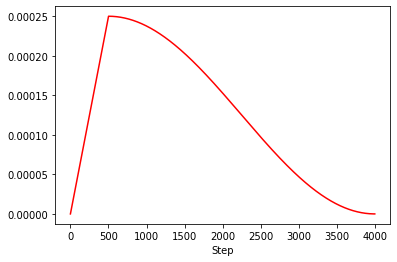

In [54]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

이제 모델을 실제로 빌드해 봅시다.

In [55]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 256),        4485632     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                            

이제 본격적으로 학습을 진행합니다.

In [56]:
epochs = 10
batch_size = 64

# optimizer
# matn.ceil: 올림값사용
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


학습시킨 모델을 콜백 함수를 사용해 저장하고, 시각화해 봅시다

In [61]:
!ls

drive		   ko_8000.model  labels_mlm.memmap  sample_data
enc_tokens.memmap  ko_8000.vocab  labels_nsp.memmap  segments.memmap


In [62]:
model_dir = '/content'
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
2000/2000 [==============================] - ETA: 0s - loss: 19.5908 - nsp_loss: 0.6511 - mlm_loss: 18.9397 - nsp_acc: 0.5887 - mlm_lm_acc: 0.1093
Epoch 1: mlm_lm_acc improved from -inf to 0.10928, saving model to /content/bert_pre_train.hdf5
2000/2000 [==============================] - 260s 128ms/step - loss: 19.5908 - nsp_loss: 0.6511 - mlm_loss: 18.9397 - nsp_acc: 0.5887 - mlm_lm_acc: 0.1093
Epoch 2/10
2000/2000 [==============================] - ETA: 0s - loss: 17.5413 - nsp_loss: 0.6241 - mlm_loss: 16.9172 - nsp_acc: 0.6168 - mlm_lm_acc: 0.1296
Epoch 2: mlm_lm_acc improved from 0.10928 to 0.12960, saving model to /content/bert_pre_train.hdf5
2000/2000 [==============================] - 256s 128ms/step - loss: 17.5413 - nsp_loss: 0.6241 - mlm_loss: 16.9172 - nsp_acc: 0.6168 - mlm_lm_acc: 0.1296
Epoch 3/10
2000/2000 [==============================] - ETA: 0s - loss: 16.4773 - nsp_loss: 0.6153 - mlm_loss: 15.8620 - nsp_acc: 0.6278 - mlm_lm_acc: 0.1425
Epoch 3: mlm_lm_acc i

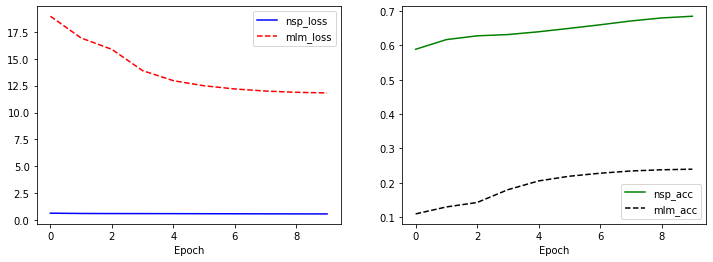

In [63]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# **회고**
프로젝트자체는 어렵진않았지만, 전체적인 개념이나 코드진행자체를 이해하기어려웠다. 처음보는 코드가 많이나와서 전체적으로 여러번 다시 봐야할듯 하다.
